In [5]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 0.2.0 ──

✔ broom        0.7.12     ✔ rsample      0.1.1 
✔ dials        1.0.0      ✔ tune         0.2.0 
✔ infer        1.0.2      ✔ workflows    0.2.6 
✔ modeldata    0.1.1      ✔ workflowsets 0.2.1 
✔ parsnip      1.0.0      ✔ yardstick    1.0.0 
✔ recipes      0.2.0      

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filte

In [6]:
ckd_data <- read_csv("https://raw.githubusercontent.com/callen02/DSCI100_Group_25_Project/main/ckd_clean.csv")
names(ckd_data) <- gsub(" ", ".", names(ckd_data))
#filtered out columns that are non numeric
ckd_data_tidy <- ckd_data %>% 
            mutate(Class = as_factor(Class)) %>%
            select(-Red.Blood.Cells, -Pus.Cell, -Pus.Cell.clumps, -Bacteria, -Hypertension, -Diabetes.Mellitus, -Appetite, -Pedal.Edema, -Coronary.Artery.Disease, - Anemia)
ckd_data_tidy

Rows: 158 Columns: 25
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): Red Blood Cells, Pus Cell, Pus Cell clumps, Bacteria, Hypertension...
dbl (15): Age, Blood Pressure, Specific Gravity, Albumin, Sugar, Blood Gluco...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Age,Blood.Pressure,Specific.Gravity,Albumin,Sugar,Blood.Glucose.Random,Blood.Urea,Serum.Creatinine,Sodium,Potassium,Hemoglobin,Packed.Cell.Volume,White.Blood.Cell.Count,Red.Blood.Cell.Count,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
48,70,1.005,4,0,117,56,3.8,111,2.5,11.2,32,6700,3.9,1
53,90,1.020,2,0,70,107,7.2,114,3.7,9.5,29,12100,3.7,1
63,70,1.010,3,0,380,60,2.7,131,4.2,10.8,32,4500,3.8,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,80,1.020,0,0,100,26,0.6,137,4.4,15.8,49,6600,5.4,0
17,60,1.025,0,0,114,50,1.0,135,4.9,14.2,51,7200,5.9,0
58,80,1.025,0,0,131,18,1.1,141,3.5,15.8,53,6800,6.1,0


First, to decide what variable we would use for our classification problem, we used ggpairs from the GGally package, which includes the distributions and the correlations of the different variables in the data set. Because we had 10+ variables, we splitted the data in 2 so we could better visualize the different plots.

In [20]:
#Importing package GGally

install.packages ("GGally")
library (GGally)

#Splitting ckd_data_tidy in 2

ckd_data_tidy_1 <- select (ckd_data_tidy,
                            Age: Blood.Urea, Class)

#ckd_data_tidy_1

ckd_data_tidy_2 <- select (ckd_data_tidy, Serum.Creatinine:Class)

#ckd_data_tidy_2


Installing package into ‘/home/jupyter/R/x86_64-pc-linux-gnu-library/4.1’
(as ‘lib’ is unspecified)



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



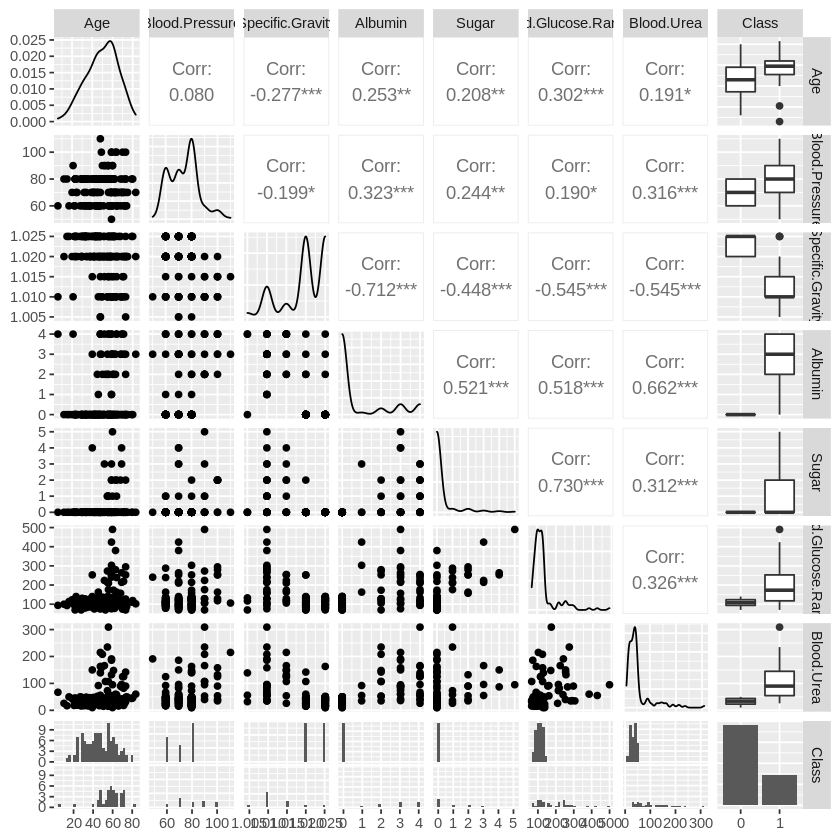

In [22]:
#ggpairs for ckd_data_tidy_1

ggpairs (ckd_data_tidy_1)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



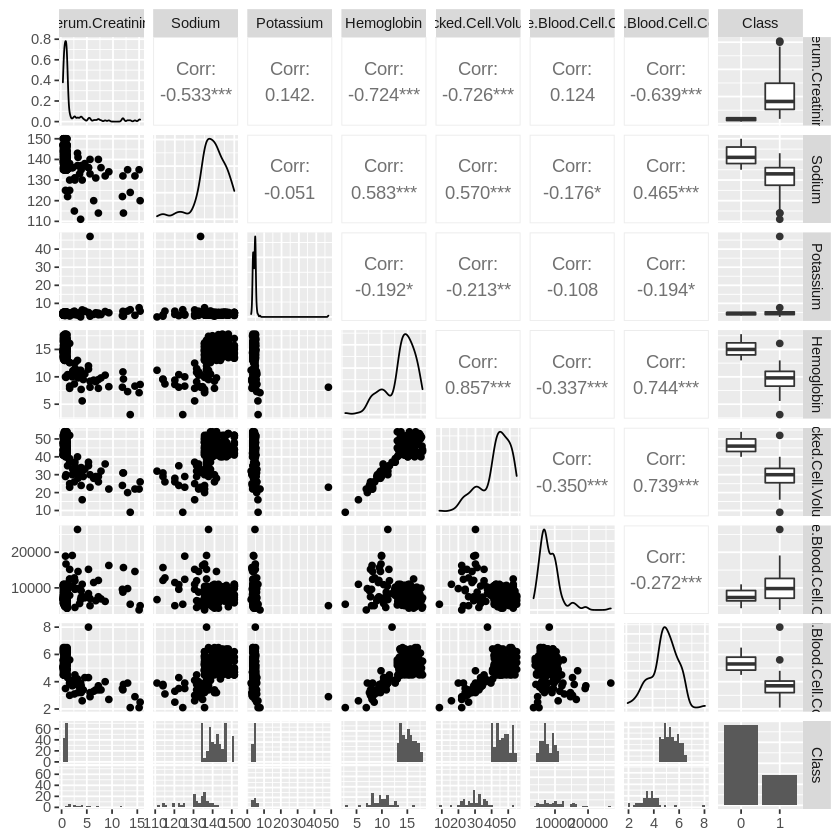

In [24]:
#ggpairs for ckd_data_tidy_2

ggpairs (ckd_data_tidy_2)


Based on the box plots, using the 3 variables that had the highest distribution towards class = 1 (having ckd), we calculated the r value (point biserial correlation) for Serum.Creatinine, Blood.Pressure and Albumin.


In [28]:
#Correlation test for Serum.Creatinine:

#Convert categorical to numerical
ckd_data_tidy$Class2 <- ifelse(ckd_data_tidy$Class==1, 1, 0)

#correlation test
cor.test(ckd_data_tidy$Serum.Creatinine, ckd_data_tidy$Class2)


	Pearson's product-moment correlation

data:  ckd_data_tidy$Serum.Creatinine and ckd_data_tidy$Class2
t = 12.319, df = 156, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6133113 0.7735344
sample estimates:
      cor 
0.7022065 


In [30]:
#Correlation test for Blood.Pressure:

#Convert categorical to numerical
ckd_data_tidy$Class2 <- ifelse(ckd_data_tidy$Class==1, 1, 0)

#correlation test
cor.test(ckd_data_tidy$Blood.Pressure, ckd_data_tidy$Class2)


	Pearson's product-moment correlation

data:  ckd_data_tidy$Blood.Pressure and ckd_data_tidy$Class2
t = 4.3154, df = 156, p-value = 2.818e-05
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1795838 0.4592882
sample estimates:
      cor 
0.3265671 


In [31]:
#Correlation test for Albumin:

#Convert categorical to numerical
ckd_data_tidy$Class2 <- ifelse(ckd_data_tidy$Class==1, 1, 0)

#correlation test
cor.test(ckd_data_tidy$Albumin, ckd_data_tidy$Class2)


	Pearson's product-moment correlation

data:  ckd_data_tidy$Albumin and ckd_data_tidy$Class2
t = 30.593, df = 156, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.8997398 0.9453057
sample estimates:
      cor 
0.9258162 


In [16]:
#training and testing data, # class means whether they have CKD or not. 1 = Yes, 0 = No
set.seed(123)
ckd_split <- initial_split(ckd_data_tidy, prop = 0.75, strata = Class)
ckd_training <- training(ckd_split)
ckd_testing <- testing(ckd_split)

ckd_training
ckd_testing

Age,Blood.Pressure,Specific.Gravity,Albumin,Sugar,Blood.Glucose.Random,Blood.Urea,Serum.Creatinine,Sodium,Potassium,Hemoglobin,Packed.Cell.Volume,White.Blood.Cell.Count,Red.Blood.Cell.Count,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
57,80,1.025,0,0,119,17,1.2,135,4.7,15.4,42,6200,6.2,0
51,60,1.025,0,0,99,38,0.8,135,3.7,13.0,49,8300,5.2,0
34,80,1.025,0,0,121,27,1.2,144,3.9,13.6,52,9200,6.3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
64,100,1.015,4,2,163,54,7.2,140,4.6,7.9,26,7500,3.4,1
59,50,1.010,3,0,241,191,12.0,114,2.9,9.6,31,15700,3.8,1
59,70,1.010,1,3,424,55,1.7,138,4.5,12.6,37,10200,4.1,1


Age,Blood.Pressure,Specific.Gravity,Albumin,Sugar,Blood.Glucose.Random,Blood.Urea,Serum.Creatinine,Sodium,Potassium,Hemoglobin,Packed.Cell.Volume,White.Blood.Cell.Count,Red.Blood.Cell.Count,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
48,70,1.005,4,0,117,56,3.8,111,2.5,11.2,32,6700,3.9,1
68,80,1.010,3,2,157,90,4.1,130,6.4,5.6,16,11000,2.6,1
61,80,1.015,2,0,173,148,3.9,135,5.2,7.7,24,9200,3.2,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,60,1.025,0,0,105,39,0.5,135,3.9,14.7,43,5800,6.2,0
33,80,1.025,0,0,89,19,1.1,144,5.0,15.0,40,10300,4.8,0
43,60,1.025,0,0,117,45,0.7,141,4.4,13.0,54,7400,5.4,0


In [9]:
#Recipe
#selection of variables of what I imagine is of more imporant when determining CKD
ckd_recipe <- recipe(Class ~ Blood.Pressure + Albumin + Age + Blood.Glucose.Random + 
                     Blood.Urea, data = ckd_training) %>%
            step_scale(all_predictors()) %>%
            step_center(all_predictors())
ckd_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          5

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [10]:
#Model that helps find the optimal K value
ckd_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
       set_engine("kknn") %>%
       set_mode("classification")
ckd_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [11]:
#10 V-fold function
ckd_vfold <- vfold_cv(ckd_training, v = 10, strata = Class)

In [12]:
#Workflow, honestly don't know if it is correct
ckd_workflow <- workflow() %>%
            add_recipe(ckd_recipe) %>%
            add_model(ckd_spec) %>%
            tune_grid(resamples = ckd_vfold, grid = 10) %>%
            collect_metrics()
            
ckd_workflow
            

ERROR: [1m[33mError[39m in [1m[1m`check_installs()`:[22m
[33m![39m Some package installs are required: 
[36m•[39m 'kknn', 'kknn'


In [ ]:
#Filter for accuracy
ckd_accuracy <- ckd_workflow %>%
                 filter(.metric == "accuracy")
ckd_accuracy

In [ ]:
#Plot to find the optimal K
cross_val_plot <- ckd_accuracy %>%
                  ggplot(aes(x= neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Neighbors Count", y = "Accuracy", title = "Neighbors Count vs Accuracy")

cross_val_plot

In [ ]:
#Model with optimal k value
ckd_optimal_k <- nearest_neighbor(weight_func = "rectangular", neighbor = 4) %>%
                set_engine("kknn") %>%
                set_mode("classification")

ckd_optimal_k
            

In [ ]:
#Fitted Model
ckd_fit <- workflow() %>%
             add_recipe(ckd_recipe) %>%
             add_model(ckd_optimal_k) %>%
             fit(data = ckd_training)

ckd_fit

In [ ]:
#Predictions and accuracy, seems awfully high but I can't tell if I made an error
set.seed(300)
ckd_predictions <- predict(ckd_fit, ckd_testing) %>%
                     bind_cols(ckd_testing)
ckd_predictions

ckd_metrics <- ckd_predictions %>%
                 metrics(truth = Class, .pred_class) %>%
                 filter(.metric== "accuracy")
ckd_metrics

In [ ]:
#Sample 
new_obs <- tibble(Blood.Pressure = 120, Age = 65, Albumin = 4, Blood.Glucose.Random = 350, Blood.Urea = 210) 
ckd_new_obs <- predict(ckd_fit, new_obs)
ckd_new_obs